In [2]:
import torch 
from llms_from_scratch.ch04 import GPTModel

In [4]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 256, # Shortened context length (orig: 1024)
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-key-value bias
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

In [9]:
import os
import urllib.request
from llms_from_scratch.ch02 import create_dataloader_v1
file_path = "../../the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_mainchapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
torch.manual_seed(123)
train_loader = create_dataloader_v1(
text_data[:split_idx],
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=True,
shuffle=True
)
val_loader = create_dataloader_v1(
text_data[split_idx:],
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=False,
shuffle=False
)

In [10]:
n_epochs = 15
initial_lr = 0.0001
peak_lr = 0.01
warmup_steps = 20

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
lr_increment = (peak_lr - initial_lr) / warmup_steps

global_step = -1
track_lrs = []
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:
            lr = peak_lr

        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        track_lrs.append(optimizer.param_groups[0]["lr"])

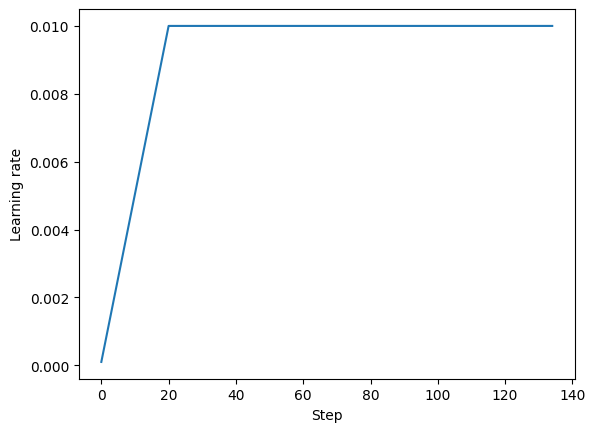

In [12]:
import matplotlib.pyplot as plt
plt.ylabel("Learning rate")
plt.xlabel("Step")
total_training_steps = len(train_loader) * n_epochs
plt.plot(range(total_training_steps), track_lrs);
plt.show()

In [13]:
import math

min_lr = 0.1 * initial_lr
track_lrs = []
lr_increment = (peak_lr - initial_lr) / warmup_steps
global_step = -1
for epoch in range(n_epochs):
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad()
        global_step += 1
        if global_step < warmup_steps:
            lr = initial_lr + global_step * lr_increment
        else:# #B
            progress = ((global_step - warmup_steps) /
            (total_training_steps - warmup_steps))
            lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
            track_lrs.append(optimizer.param_groups[0]["lr"])

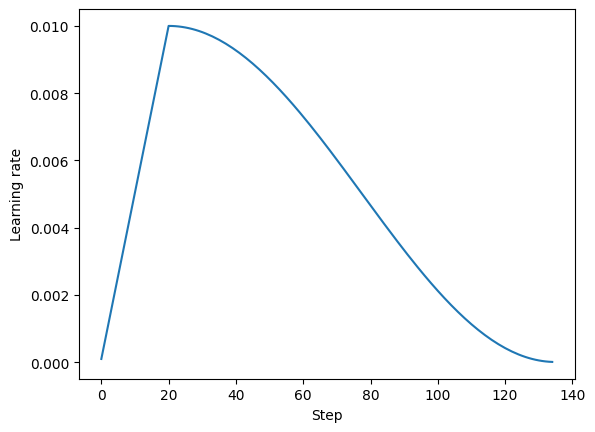

In [14]:
plt.ylabel("Learning rate")
plt.xlabel("Step")
plt.plot(range(total_training_steps), track_lrs)
plt.show()

In [15]:
from llms_from_scratch.ch05 import calc_loss_batch

In [16]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
loss = calc_loss_batch(input_batch, target_batch, model, device)
loss.backward()

In [18]:
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
        if max_grad is None or max_grad_param > max_grad:
            max_grad = max_grad_param
    return max_grad
print(find_highest_gradient(model))

tensor(0.0411)


In [19]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
print(find_highest_gradient(model))

tensor(0.0185)


In [20]:
from llms_from_scratch.ch05 import evaluate_model, generate_and_print_sample

In [23]:
def train_model(model, train_loader, val_loader, optimizer, device, n_epochs,
eval_freq, eval_iter, start_context, warmup_steps=10, initial_lr=3e-05, min_lr=1e-6):
    
    train_losses, val_losses, track_tokens_seen, track_lr = [], [], [], []
    tokens_seen, global_step = 0, -1

    peak_lr = optimizer.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps
    
    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step +=1

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment
            else:
                progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lr.append(lr)
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                model, train_loader, val_loader,
                device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(
            model, train_loader.dataset.tokenizer,
            device, start_context
            )
    return train_losses, val_losses, track_tokens_seen, track_lrs

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
peak_lr = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
n_epochs = 15
train_losses, val_losses, tokens_seen, lrs = train_model(
model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
eval_freq=5, eval_iter=1, start_context="Every effort moves you",
warmup_steps=10, initial_lr=1e-5, min_lr=1e-5
)

Ep 1 (Iter 000000): Train loss 10.934, Val loss 10.939
Ep 1 (Iter 000005): Train loss 8.529, Val loss 8.843
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 6.400, Val loss 6.825
Ep 2 (Iter 000015): Train loss 6.116, Val loss 6.861
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 6.033, Val loss 6.904
Ep 3 (Iter 000025): Train loss 5.915, Val loss 6.851
Every effort moves you, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the
Ep 4 (Iter 000030): Train loss 5.375, Val loss 6.815
Ep 4 (Iter 000035): Train loss 5.000, Val loss 6.701
Every effort moves you.                                                 
Ep 5 (Iter 000040): Train loss 4.984, Val loss 6.634
Every effort moves you of the                                                
Ep 6 (Iter 000045): Train loss 3.858, Val loss 6.507
Ep 6 (Iter 000050): Tra